In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

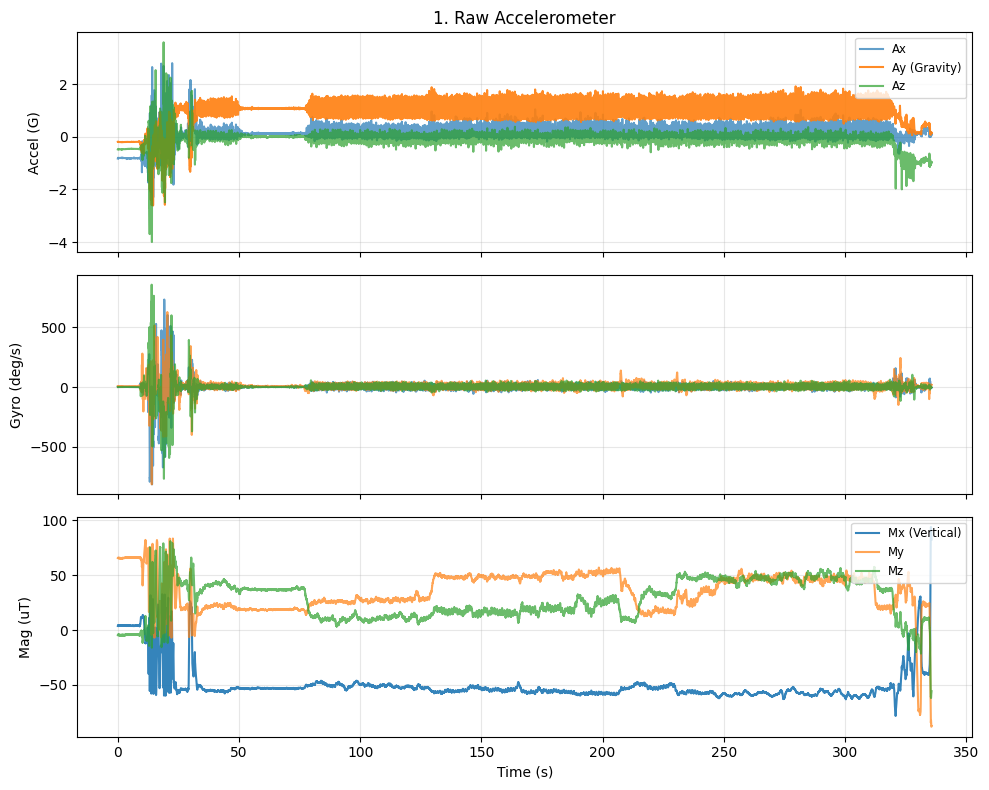

In [15]:
# --- Configuration ---
USER_HEIGHT = 2.2      # Not true, just scaling to match gps path
START_PCT = 0.30       # Skip messy start
MOVING_THRESH = 0.05   # G-force variance threshold
ALIGN_HEADINGS = False # Set True to force PDR to match GPS start

# Load Data
file_path = '/home/ollie/Documents/PlatformIO/Projects/lokata/data/raw/walk_data_20260119-160414.csv'
df = pd.read_csv(file_path)

# Normalize Time & GPS
df['Time'] = (df['Micros'] - df['Micros'].iloc[0]) / 1e6
df['Lat_Deg'] = df['Lat'] / 1e7
df['Lon_Deg'] = df['Lon'] / 1e7

# ==========================================
# 1. RAW DATA INSPECTION
# ==========================================
fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# Accelerometer
axs[0].plot(df['Time'], df['Ax'], label='Ax', alpha=0.7)
axs[0].plot(df['Time'], df['Ay'], label='Ay (Gravity)', alpha=0.9)
axs[0].plot(df['Time'], df['Az'], label='Az', alpha=0.7)
axs[0].set_ylabel('Accel (G)')
axs[0].set_title('1. Raw Accelerometer')
axs[0].legend(loc='upper right', fontsize='small')
axs[0].grid(True, alpha=0.3)

# Gyroscope
axs[1].plot(df['Time'], df['Gx'], label='Gx', alpha=0.7)
axs[1].plot(df['Time'], df['Gy'], label='Gy', alpha=0.7)
axs[1].plot(df['Time'], df['Gz'], label='Gz', alpha=0.7)
axs[1].set_ylabel('Gyro (deg/s)')
axs[1].grid(True, alpha=0.3)

# Magnetometer
axs[2].plot(df['Time'], df['Mx'], label='Mx (Vertical)', alpha=0.9)
axs[2].plot(df['Time'], df['My'], label='My', alpha=0.7)
axs[2].plot(df['Time'], df['Mz'], label='Mz', alpha=0.7)
axs[2].set_ylabel('Mag (uT)')
axs[2].set_xlabel('Time (s)')
axs[2].legend(loc='upper right', fontsize='small')
axs[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

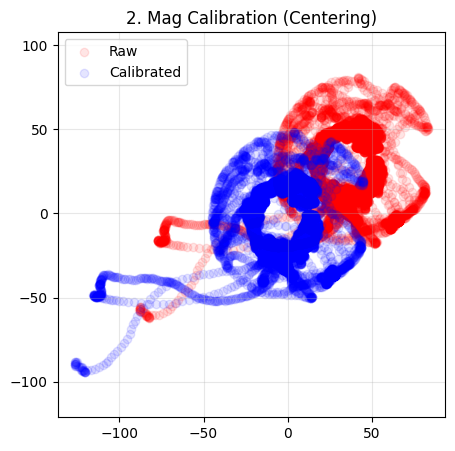

In [16]:
# ==========================================
# 2. CALIBRATION (HARD IRON)
# ==========================================
# Use first 60s to center the sphere
calib_subset = df[df['Time'] < 60]

mx_bias = (calib_subset['Mx'].max() + calib_subset['Mx'].min()) / 2
my_bias = (calib_subset['My'].max() + calib_subset['My'].min()) / 2
mz_bias = (calib_subset['Mz'].max() + calib_subset['Mz'].min()) / 2

df['Mx_cal'] = df['Mx'] - mx_bias
df['My_cal'] = df['My'] - my_bias
df['Mz_cal'] = df['Mz'] - mz_bias

# Visual check of the horizontal plane
plt.figure(figsize=(5, 5))
plt.scatter(df['My'], df['Mz'], alpha=0.1, color='red', label='Raw')
plt.scatter(df['My_cal'], df['Mz_cal'], alpha=0.1, color='blue', label='Calibrated')
plt.title('2. Mag Calibration (Centering)')
plt.axis('equal')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

--- STEP ANALYSIS ---
Window Duration: 170.6s
Detected Steps: 327
Predicted Steps (approx): 298


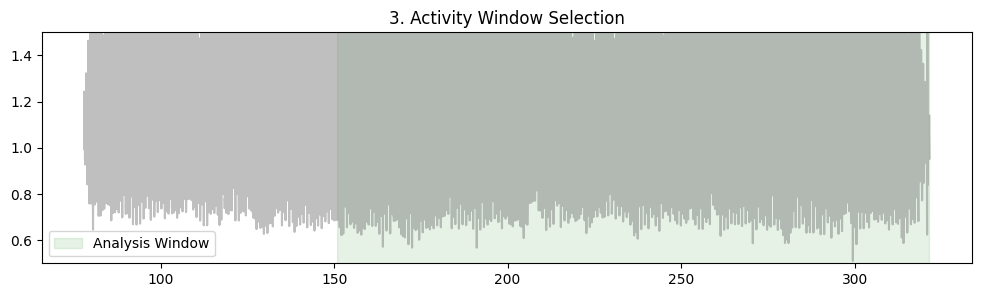

In [17]:
# ==========================================
# 3. ACTIVITY DETECTION
# ==========================================
# G-Force Variance check
df['Acc_Mag'] = np.sqrt(df['Ax']**2 + df['Ay']**2 + df['Az']**2)
df['Motion_Var'] = df['Acc_Mag'].rolling(window=50).std()
df['Is_Moving'] = df['Motion_Var'] > MOVING_THRESH

# Isolate longest segment
df['segment_id'] = (df['Is_Moving'] != df['Is_Moving'].shift()).cumsum()
moving_segs = df[df['Is_Moving'] == True]
longest_seg_id = moving_segs.groupby('segment_id').size().idxmax()
full_walk = df[df['segment_id'] == longest_seg_id].copy()

# Apply Start % Slice
start_idx = int(len(full_walk) * START_PCT)
walk_data = full_walk.iloc[start_idx:].copy()

# --- STEP COUNT DIAGNOSTICS ---
# Sanity check: approx 100-110 steps/min is normal walking
duration = walk_data['Time'].iloc[-1] - walk_data['Time'].iloc[0]
est_steps = int((duration / 60) * 105) 

peaks, _ = find_peaks(walk_data['Acc_Mag'], height=1.05, distance=35, prominence=0.1)
print(f"--- STEP ANALYSIS ---")
print(f"Window Duration: {duration:.1f}s")
print(f"Detected Steps: {len(peaks)}")
print(f"Predicted Steps (approx): {est_steps}")

# Plot Motion Mask
plt.figure(figsize=(12, 3))
plt.plot(full_walk['Time'], full_walk['Acc_Mag'], color='gray', alpha=0.5)
plt.fill_between(walk_data['Time'], 0, 2, color='green', alpha=0.1, label='Analysis Window')
plt.title('3. Activity Window Selection')
plt.ylim(0.5, 1.5)
plt.legend()
plt.show()

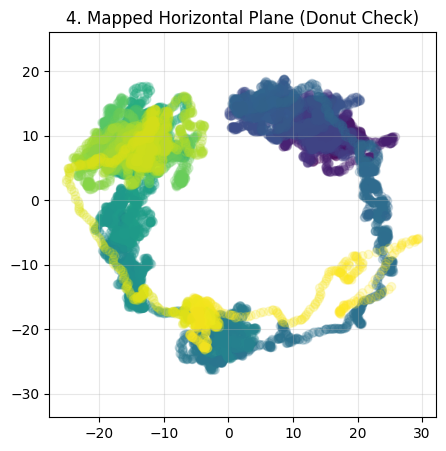

In [18]:
# ==========================================
# 4. CROSS-AXIS MAPPING
# ==========================================
# Hardware: Ay=Gravity, Mx=Vertical.
# Fix: Inverting Mz corrected the mirror issue previously.
subset = walk_data.copy()

subset['Az_new'] = subset['Ay'] # Down
subset['Ax_new'] = subset['Az'] # Fwd
subset['Ay_new'] = subset['Ax'] # Right

subset['Mz_new'] = subset['Mx_cal']  # Down
subset['Mx_new'] = -subset['Mz_cal'] # Fwd (Inverted)
subset['My_new'] = subset['My_cal']  # Right

# Verify Horizontal Plane
plt.figure(figsize=(5, 5))
plt.scatter(subset['Mx_new'], subset['My_new'], alpha=0.2, c=subset['Time'])
plt.title('4. Mapped Horizontal Plane (Donut Check)')
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()

Start Offset (GPS - PDR): 48.5 deg


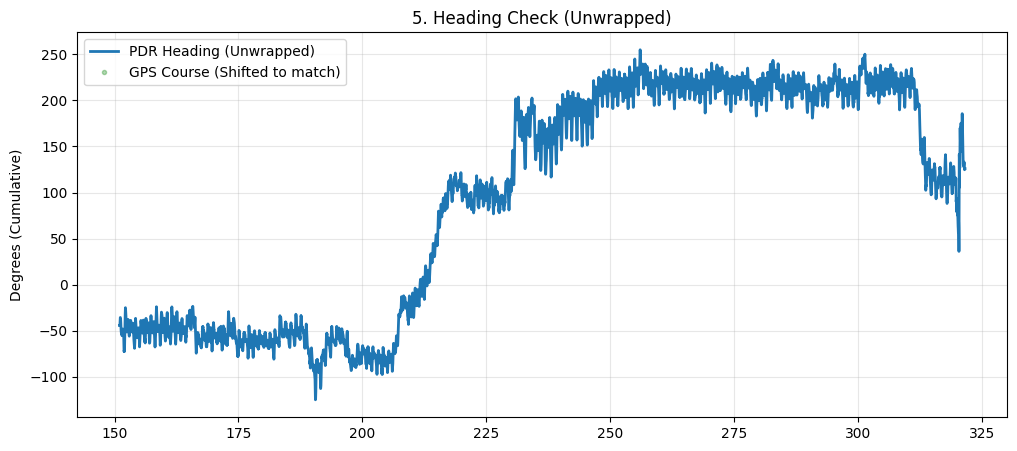

In [ ]:
# ==========================================
# 5. AHRS & HEADING
# ==========================================
# VECTORIZATION: Extract arrays for speed (replaces slow iterrows loop)
ax, ay, az = subset['Ax_new'].values, subset['Ay_new'].values, subset['Az_new'].values
mx, my, mz = subset['Mx_new'].values, subset['My_new'].values, subset['Mz_new'].values

# Standard Tilt-Compensated Compass Math (Applied to whole array)
roll = np.arctan2(ay, az)
pitch = np.arctan2(-ax, np.sqrt(ay**2 + az**2))

Xh = mx * np.cos(pitch) + mz * np.sin(pitch)
Yh = mx * np.sin(roll) * np.sin(pitch) + my * np.cos(roll) - mz * np.sin(roll) * np.cos(pitch)

headings = np.arctan2(-Yh, Xh)

# Smoothing
subset['H_Sin'] = np.sin(headings)
subset['H_Cos'] = np.cos(headings)
subset['H_Sin_Sm'] = subset['H_Sin'].rolling(15, center=True).mean().bfill().ffill()
subset['H_Cos_Sm'] = subset['H_Cos'].rolling(15, center=True).mean().bfill().ffill()
subset['Heading_Final'] = np.arctan2(subset['H_Sin_Sm'], subset['H_Cos_Sm'])

# Optional Alignment
gps_subset = df[(df['Time'] >= subset['Time'].min()) & (df['Time'] <= subset['Time'].max())].copy()

if len(gps_subset) > 5:
    d_lat = gps_subset['Lat_Deg'].diff()
    d_lon = gps_subset['Lon_Deg'].diff()
    gps_course = np.arctan2(d_lon, d_lat)
    
    # Calculate Offset (Using Vector Averaging, not Arithmetic Mean)
    align_end = subset['Time'].min() + 10
    
    # GPS Mean
    mask_gps = gps_subset['Time'] < align_end
    gps_sin = np.sin(gps_course[mask_gps]).mean()
    gps_cos = np.cos(gps_course[mask_gps]).mean()
    gps_head = np.arctan2(gps_sin, gps_cos)

    # PDR Mean
    mask_pdr = subset['Time'] < align_end
    pdr_sin = np.sin(subset.loc[mask_pdr, 'Heading_Final']).mean()
    pdr_cos = np.cos(subset.loc[mask_pdr, 'Heading_Final']).mean()
    pdr_head = np.arctan2(pdr_sin, pdr_cos)

    offset = gps_head - pdr_head
    print(f"Start Offset (GPS - PDR): {np.degrees(offset):.1f} deg")

    if ALIGN_HEADINGS:
        subset['Heading_Used'] = subset['Heading_Final'] + offset
    else:
        subset['Heading_Used'] = subset['Heading_Final']
else:
    # Fallback if no GPS
    subset['Heading_Used'] = subset['Heading_Final']

# --- HEADING DIAGNOSTIC PLOT (UNWRAPPED) ---
# Unwrap allows us to see the trend without 360 degree jumps
pdr_unwrap = np.degrees(np.unwrap(subset['Heading_Used']))
gps_unwrap = np.degrees(np.unwrap(gps_course))

# Shift GPS visually to overlap PDR for shape comparison
# Handle potential empty GPS data gracefully for plot
if len(gps_unwrap) > 0:
    vis_offset = pdr_unwrap[0] - gps_unwrap[0] 
else:
    vis_offset = 0

plt.figure(figsize=(12, 5))
plt.plot(subset['Time'], pdr_unwrap, label='PDR Heading (Unwrapped)', lw=2)
if len(gps_subset) > 0:
    plt.plot(gps_subset['Time'], gps_unwrap + vis_offset, 'g.', label='GPS Course (Shifted to match)', alpha=0.3)
plt.title('5. Heading Check (Unwrapped)')
plt.ylabel('Degrees (Cumulative)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

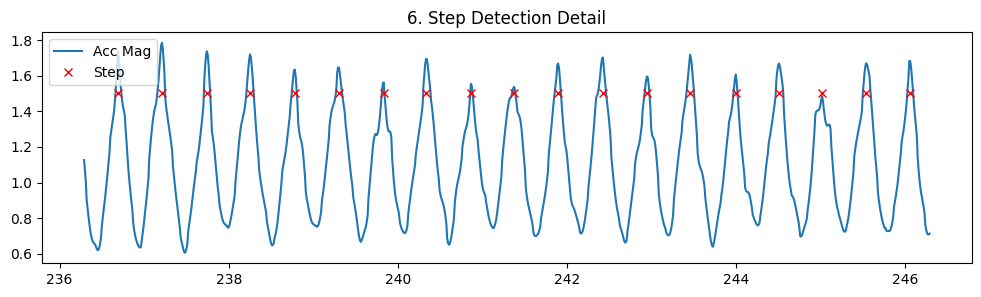

In [20]:
# ==========================================
# 6. INTEGRATION
# ==========================================
# Find peaks in the subset
subset_peaks = [p for p in peaks if (p + walk_data.index[0]) in subset.index]

# --- ZOOMED STEP CHECK ---
# Verify we are catching steps correctly
mid = int(len(subset)/2)
zoom = subset.iloc[mid : mid+1000]
zoom_peaks = [p for p in subset_peaks if (p + walk_data.index[0]) in zoom.index]
peak_times = walk_data['Time'].iloc[zoom_peaks] # Map back to time

plt.figure(figsize=(12, 3))
plt.plot(zoom['Time'], zoom['Acc_Mag'], label='Acc Mag')
plt.plot(peak_times, [1.5]*len(zoom_peaks), "rx", label='Step')
plt.title('6. Step Detection Detail')
plt.legend()
plt.show()

# Run Integration
x_pos, y_pos = [0], [0]
curr_x, curr_y = 0, 0
base_step = USER_HEIGHT * 0.415

for p in subset_peaks:
    idx = subset.index.get_loc(p + walk_data.index[0])
    h = subset['Heading_Used'].iloc[idx]
    
    impact = subset['Acc_Mag'].iloc[idx]
    scale = np.sqrt(impact - 0.9)
    step_len = np.clip(base_step * scale, 0.5, 1.3)
    
    curr_x += step_len * np.cos(h)
    curr_y += step_len * np.sin(h)
    x_pos.append(curr_x)
    y_pos.append(curr_y)

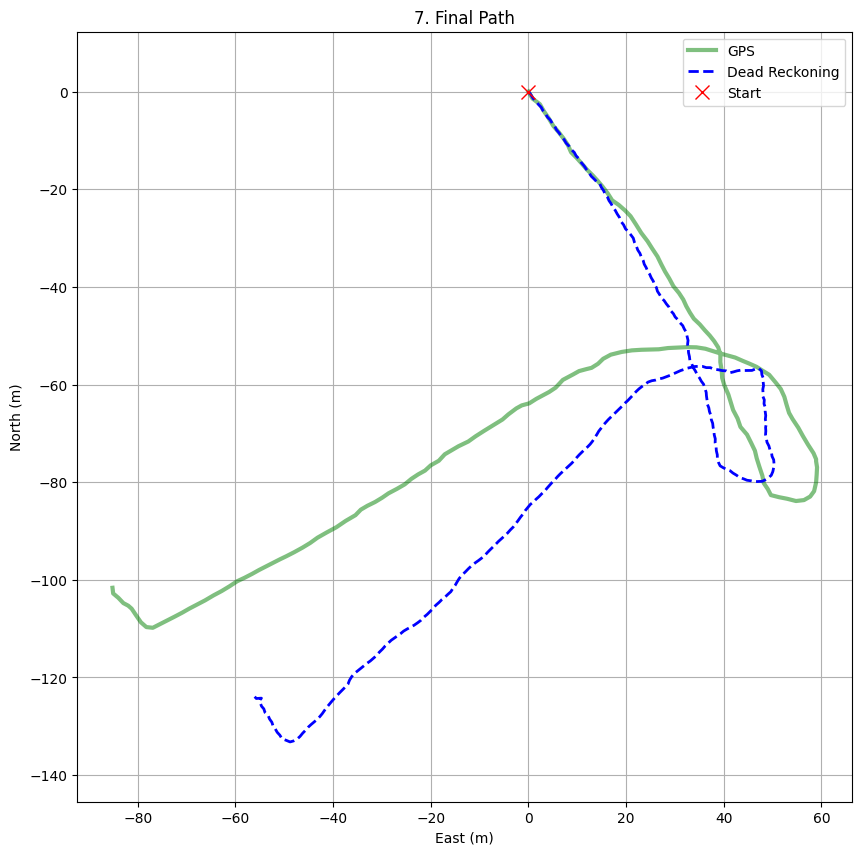

In [21]:
# ==========================================
# 7. FINAL PATH
# ==========================================
plt.figure(figsize=(10, 10))

if len(gps_subset) > 0:
    lat0, lon0 = gps_subset['Lat_Deg'].iloc[0], gps_subset['Lon_Deg'].iloc[0]
    gps_y = (gps_subset['Lat_Deg'] - lat0) * 111132 
    gps_x = (gps_subset['Lon_Deg'] - lon0) * 78847
    plt.plot(gps_x, gps_y, 'g-', lw=3, alpha=0.5, label='GPS')

plt.plot(x_pos, y_pos, 'b--', lw=2, label='Dead Reckoning')
plt.plot(0, 0, 'rx', ms=10, label='Start')

plt.title('7. Final Path')
plt.xlabel('East (m)')
plt.ylabel('North (m)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()